## User and Entity Behaviors Analytics

### Supervised Learning Models for Binary Outcomes

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot


def describe_more(df,normalize_ind=False, weight_column=None, skip_columns=[], dropna=True):
    var = [] ; l = [] ; t = []; unq =[]; min_l = []; max_l = [];
    assert isinstance(skip_columns, list), "Argument skip_columns should be list"
    if weight_column is not None:
        if weight_column not in list(df.columns):
            raise AssertionError('weight_column is not a valid column name in the input DataFrame')
      
    for x in df:
        if x in skip_columns:
            pass
        else:
            var.append( x )
            uniq_counts = len(pd.value_counts(df[x],dropna=dropna))
            uniq_counts = len(pd.value_counts(df[x], dropna=dropna)[pd.value_counts(df[x],dropna=dropna)>0])
            l.append(uniq_counts)
            t.append( df[ x ].dtypes )
            min_l.append(df[x].apply(str).str.len().min())
            max_l.append(df[x].apply(str).str.len().max())
            if weight_column is not None and x not in skip_columns:
                df2 = df.groupby(x).agg({weight_column: 'sum'}).sort_values(weight_column, ascending=False)
                df2['authtrans_vts_cnt']=((df2[weight_column])/df2[weight_column].sum()).round(2)
                unq.append(df2.head(n=100).to_dict()[weight_column])
            else:
                df_cat_d = df[x].value_counts(normalize=normalize_ind,dropna=dropna).round(decimals=2)
                df_cat_d = df_cat_d[df_cat_d>0]
                #unq.append(df[x].value_counts().iloc[0:100].to_dict())
                unq.append(df_cat_d.iloc[0:100].to_dict())
            
    levels = pd.DataFrame( { 'A_Variable' : var , 'Levels' : l , 'Datatype' : t ,
                             'Min Length' : min_l,
                             'Max Length': max_l,
                             'Level_Values' : unq} )
    #levels.sort_values( by = 'Levels' , inplace = True )
    return levels

### Data Preparation

In [2]:
# Load data
X_train = pd.read_csv('SCVIC-APT-2021-Training.csv')
X_test = pd.read_csv('SCVIC-APT-2021-Testing.csv')

In [4]:
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (259120, 84)
Test shape: (56487, 84)


In [11]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259120 entries, 0 to 259119
Data columns (total 78 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Flow ID                     259119 non-null  object 
 1   Flow Duration               259120 non-null  int64  
 2   Total Fwd Packet            259120 non-null  int64  
 3   Total Bwd packets           259120 non-null  int64  
 4   Total Length of Fwd Packet  259120 non-null  float64
 5   Total Length of Bwd Packet  259120 non-null  float64
 6   Fwd Packet Length Max       259120 non-null  float64
 7   Fwd Packet Length Min       259120 non-null  float64
 8   Fwd Packet Length Mean      259120 non-null  float64
 9   Fwd Packet Length Std       259120 non-null  float64
 10  Bwd Packet Length Max       259120 non-null  float64
 11  Bwd Packet Length Min       259120 non-null  float64
 12  Bwd Packet Length Mean      259120 non-null  float64
 13  Bwd Packet Len

In [5]:
# Review Dataset
# pd.set_option('display.max_columns', None)
X_train.head()

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,172.28.128.11-172.28.128.10-49331-389-6,172.28.128.11,49331,172.28.128.10,389,6,2015-10-21 09:54:02,4975,11,32,...,20,0.0,0.0,0.0,0.0,1.602165e+15,0.0,1.602165e+15,1.602165e+15,NormalTraffic
1,172.28.128.11-172.28.128.10-49332-389-6,172.28.128.11,49332,172.28.128.10,389,6,2015-10-21 09:54:02,4110,9,7,...,20,0.0,0.0,0.0,0.0,1.602165e+15,0.0,1.602165e+15,1.602165e+15,NormalTraffic
2,8.6.0.1-8.0.6.4-0-0-0,8.6.0.1,0,8.0.6.4,0,0,2015-10-21 09:54:25,1671818,3,0,...,0,0.0,0.0,0.0,0.0,1.602165e+15,0.0,1.602165e+15,1.602165e+15,NormalTraffic
3,8.6.0.1-8.0.6.4-0-0-0,8.6.0.1,0,8.0.6.4,0,0,2015-10-21 09:57:10,1672538,3,0,...,0,0.0,0.0,0.0,0.0,1.602165e+15,0.0,1.602165e+15,1.602165e+15,NormalTraffic
4,172.28.128.10-172.28.128.255-137-137-17,172.28.128.10,137,172.28.128.255,137,17,2015-10-21 09:54:20,2281415,4,0,...,8,0.0,0.0,0.0,0.0,1.602165e+15,0.0,1.602165e+15,1.602165e+15,NormalTraffic


In [6]:
X_train.describe()

,Src Port,Dst Port,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,...,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,259120.000000,259120.000000,259120.000000,2.591200e+05,259120.000000,259120.000000,259120.000000,2.591200e+05,259120.000000,259120.000000,...,259120.000000,259120.000000,2.591200e+05,259120.0,2.591200e+05,2.591200e+05,2.591200e+05,2.591200e+05,2.591200e+05,2.591200e+05
mean,43605.276358,4620.691834,7.704010,1.083636e+06,4.687674,2.672233,361.486944,3.182378e+02,52.661446,19.989665,...,1.906063,20.961871,1.530509e+03,0.0,1.530509e+03,1.530509e+03,1.457141e+15,2.994857e+13,1.478392e+15,1.435942e+15
std,19237.192053,10611.912850,4.546006,1.841492e+06,24.131245,9.076099,3776.697315,6.986755e+03,397.930582,121.389925,...,22.318784,10.963584,3.298022e+04,0.0,3.298022e+04,3.298022e+04,1.376273e+14,1.776384e+14,7.405100e+13,2.530104e+14
min,0.000000,0.000000,0.000000,-1.372120e+05,1.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.0,0.000000e+00,0.000000e+00,7.230000e+11,0.000000e+00,1.450000e+12,3.000172e+06
25%,40504.000000,102.000000,6.000000,6.050000e+02,1.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000,20.000000,0.000000e+00,0.0,0.000000e+00,0.000000e+00,1.450000e+15,0.000000e+00,1.450000e+15,1.450000e+15
50%,49693.000000,102.000000,6.000000,3.499000e+03,2.000000,1.000000,1.000000,0.000000e+00,1.000000,0.000000,...,0.000000,20.000000,0.000000e+00,0.0,0.000000e+00,0.000000e+00,1.450000e+15,0.000000e+00,1.450000e+15,1.450000e+15
75%,56651.000000,4466.000000,6.000000,1.003442e+06,2.000000,1.000000,93.000000,3.700000e+01,31.000000,1.000000,...,0.000000,24.000000,0.000000e+00,0.0,0.000000e+00,0.000000e+00,1.450000e+15,0.000000e+00,1.450000e+15,1.450000e+15
max,65535.000000,65389.000000,17.000000,5.000000e+06,1350.000000,2291.000000,175604.000000,3.126149e+06,32768.000000,24320.000000,...,1346.000000,44.000000,1.816401e+06,0.0,1.816401e+06,1.816401e+06,1.602213e+15,1.132940e+15,1.602213e+15,1.602213e+15


In [7]:
# Values of categorical columns
len_data = len(X_train)
for col in X_train.columns:
  if X_train[col].dtype == 'object':
    print("Column ",col," has ",X_train[col].nunique()," values")

Column  Flow ID  has  99312  values
Column  Src IP  has  94  values
Column  Dst IP  has  143  values
Column  Timestamp  has  11874  values
Column  Label  has  6  values


Since the Flow ID already contain Src IP and Dst IP, I will drop those columns

In [8]:
# Drop unused column
X_train.drop(['Timestamp', 'Src Port', 'Dst Port', 'Protocol', 'Src IP', 'Dst IP'], axis = 1, inplace=True)
X_test.drop(['Timestamp', 'Src Port', 'Dst Port', 'Protocol', 'Src IP', 'Dst IP'], axis = 1, inplace=True)

In [10]:
X_train.isna().sum().head(20)

Flow ID                          1
Flow Duration                    0
Total Fwd Packet                 0
Total Bwd packets                0
Total Length of Fwd Packet       0
Total Length of Bwd Packet       0
Fwd Packet Length Max            0
Fwd Packet Length Min            0
Fwd Packet Length Mean           0
Fwd Packet Length Std            0
Bwd Packet Length Max            0
Bwd Packet Length Min            0
Bwd Packet Length Mean           0
Bwd Packet Length Std            0
Flow Bytes/s                  1758
Flow Packets/s                   0
Flow IAT Mean                    0
Flow IAT Std                     0
Flow IAT Max                     0
Flow IAT Min                     0
dtype: int64

In [12]:
X_train.dropna(subset = ['Flow ID', 'Flow Bytes/s'], inplace=True)
X_test.dropna(subset = ['Flow ID', 'Flow Bytes/s'], inplace=True)

In [13]:
X_train.replace([np.inf, -np.inf], 0, inplace=True)
X_test.replace([np.inf, -np.inf], 0, inplace=True)

In [14]:
values_to_fill = {}

for col in X_train.columns:
    if X_train[col].dtype == 'object':
        values_to_fill[col] = "Missing"
    else:
        values_to_fill[col] = 0

X_train.fillna(value=values_to_fill,inplace=True)
X_test.fillna(value=values_to_fill, inplace=True)

**"Label" will be used as Target variable**

Encode target variable `Label` into `0` and `1`, when value is `NormalTraffic` is mapped to `0` and all other values is mapped to `1`.   

In [15]:
X_train.groupby(by=["Label"])["Label"].count()

Label
DataExfiltration        527
InitialCompromise        73
LateralMovement         728
NormalTraffic        253078
Pivoting               2122
Reconnaissance          833
Name: Label, dtype: int64

In [16]:
# Converting target variable from string to binary
X_train['Label'] = [0 if app == 'NormalTraffic' else 1 for app in X_train.Label.values]
X_test['Label'] = [0 if app == 'NormalTraffic' else 1 for app in X_test.Label.values]

In [17]:
X_train.groupby(by=["Label"])["Label"].count()

Label
0    253078
1      4283
Name: Label, dtype: int64

**Features Engineering**

In [18]:
# Values of categorical columns
len_data = len(X_train)
for col in X_train.columns:
  if X_train[col].dtype == 'object':
    print("Column ",col," has ",X_train[col].nunique()," values")

Column  Flow ID  has  98605  values


In [19]:
from sklearn.preprocessing import LabelEncoder
from copy import deepcopy

'''Save original columns that need to be droped or not used
   Save One-hot and Label encoders for future use
'''
#Columns to drop from ML models
cols_to_drop = []
#Categorical encoders disctionary
cat_encoders = {}
#New categorical (encoded) columns
cat_enc_columns = []

for col in X_train.drop(columns=['Label']).columns:
  if X_train[col].dtype == 'object':
    if X_train[col].nunique() > 1000:
        print("Label Encode scaling of ", col)
        enc = LabelEncoder()
        enc.fit(list(X_train[col])+list(X_test[col]))
        new_col_name = col+"_le"
        X_train[new_col_name] = enc.transform(X_train[[col]])
        X_test[new_col_name] = enc.transform(X_test[[col]])
        cat_encoders[col] = [deepcopy(enc),"le"]
        cat_enc_columns.append(new_col_name)

    cols_to_drop.append(col)

Label Encode scaling of  Flow ID


/Users/thienla/ml-fall-2023/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/thienla/ml-fall-2023/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


**Attention**: One-hot-encoding has several limitations:
- It produces large number of columns
- It produces sparse features, and tree based algorithms don't work well with sparse features
- It cannot deal efficiently with unseen values

In [20]:
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("New encoded columns:", cat_enc_columns)
X_train.head()

Train shape: (257361, 79)
Test shape: (55962, 79)
New encoded columns: ['Flow ID_le']


,Flow ID,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Flow ID_le
0,172.28.128.11-172.28.128.10-49331-389-6,4975,11,32,337.0,3127.0,155.0,0.0,30.636364,51.09065,...,0.0,0.0,0.0,0.0,1.602165e+15,0.0,1.602165e+15,1.602165e+15,0,18331
1,172.28.128.11-172.28.128.10-49332-389-6,4110,9,7,369.0,414.0,155.0,0.0,41.000000,57.95041,...,0.0,0.0,0.0,0.0,1.602165e+15,0.0,1.602165e+15,1.602165e+15,0,18332
2,8.6.0.1-8.0.6.4-0-0-0,1671818,3,0,0.0,0.0,0.0,0.0,0.000000,0.00000,...,0.0,0.0,0.0,0.0,1.602165e+15,0.0,1.602165e+15,1.602165e+15,0,100730
3,8.6.0.1-8.0.6.4-0-0-0,1672538,3,0,0.0,0.0,0.0,0.0,0.000000,0.00000,...,0.0,0.0,0.0,0.0,1.602165e+15,0.0,1.602165e+15,1.602165e+15,0,100730
4,172.28.128.10-172.28.128.255-137-137-17,2281415,4,0,272.0,0.0,68.0,68.0,68.000000,0.00000,...,0.0,0.0,0.0,0.0,1.602165e+15,0.0,1.602165e+15,1.602165e+15,0,18299


Use **Standard Scaler** to encode numerical variable

In [21]:
#Columns to scale
cols_numerical_sc = []
cols_numerical_orig = []
for col in X_train.drop(columns=['Label']+ cat_enc_columns + cols_to_drop):
    if pd.api.types.is_numeric_dtype(X_train[col].dtype):
        print('Column to process:', col)
        cols_numerical_orig.append(col)

Column to process: Flow Duration
Column to process: Total Fwd Packet
Column to process: Total Bwd packets
Column to process: Total Length of Fwd Packet
Column to process: Total Length of Bwd Packet
Column to process: Fwd Packet Length Max
Column to process: Fwd Packet Length Min
Column to process: Fwd Packet Length Mean
Column to process: Fwd Packet Length Std
Column to process: Bwd Packet Length Max
Column to process: Bwd Packet Length Min
Column to process: Bwd Packet Length Mean
Column to process: Bwd Packet Length Std
Column to process: Flow Bytes/s
Column to process: Flow Packets/s
Column to process: Flow IAT Mean
Column to process: Flow IAT Std
Column to process: Flow IAT Max
Column to process: Flow IAT Min
Column to process: Fwd IAT Total
Column to process: Fwd IAT Mean
Column to process: Fwd IAT Std
Column to process: Fwd IAT Max
Column to process: Fwd IAT Min
Column to process: Bwd IAT Total
Column to process: Bwd IAT Mean
Column to process: Bwd IAT Std
Column to process: Bwd 

In [22]:
from sklearn.preprocessing import StandardScaler

num_scalers = {}
'''Scale only original numerical columns'''
for col in X_train[cols_numerical_orig]:
  if pd.api.types.is_numeric_dtype(X_train[col].dtype):
    print("StandardScaler scale of ", col)
    scaler = StandardScaler()
    scaler.fit(X_train[[col]])
    X_train[col+"_sc"] = scaler.transform(X_train[[col]])
    X_test[col+"_sc"] = scaler.transform(X_test[[col]])
    
    num_scalers[col] = [deepcopy(scaler),"StandardScaler"]
    cols_numerical_sc.append(col+"_sc")
    cols_to_drop.append(col)

StandardScaler scale of  Flow Duration
StandardScaler scale of  Total Fwd Packet
StandardScaler scale of  Total Bwd packets
StandardScaler scale of  Total Length of Fwd Packet
StandardScaler scale of  Total Length of Bwd Packet
StandardScaler scale of  Fwd Packet Length Max
StandardScaler scale of  Fwd Packet Length Min
StandardScaler scale of  Fwd Packet Length Mean
StandardScaler scale of  Fwd Packet Length Std
StandardScaler scale of  Bwd Packet Length Max
StandardScaler scale of  Bwd Packet Length Min
StandardScaler scale of  Bwd Packet Length Mean
StandardScaler scale of  Bwd Packet Length Std
StandardScaler scale of  Flow Bytes/s
StandardScaler scale of  Flow Packets/s
StandardScaler scale of  Flow IAT Mean
StandardScaler scale of  Flow IAT Std
StandardScaler scale of  Flow IAT Max
StandardScaler scale of  Flow IAT Min
StandardScaler scale of  Fwd IAT Total
StandardScaler scale of  Fwd IAT Mean
StandardScaler scale of  Fwd IAT Std
StandardScaler scale of  Fwd IAT Max
StandardScal

In [23]:
print("Original numerical columns:",cols_numerical_orig)
print("Scaled numerical columns:",cols_numerical_sc)

Original numerical columns: ['Flow Duration', 'Total Fwd Packet', 'Total Bwd packets', 'Total Length of Fwd Packet', 'Total Length of Bwd Packet', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Packet Length Min', 'Packet Length Max', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'CWR Flag Count', 'ECE Flag Count

### Logistic Regression

A good choice for predicting binary outcomes (like whether an activity is malicious or not) and provides interpretable coefficients.

In [24]:
print("Will not use following columns:", "\n",cols_to_drop)
print("\n +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
print("Will be using following features:", "\n", cat_enc_columns, cols_numerical_sc)
print("\n +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")

Will not use following columns: 
 ['Flow ID', 'Flow Duration', 'Total Fwd Packet', 'Total Bwd packets', 'Total Length of Fwd Packet', 'Total Length of Bwd Packet', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Packet Length Min', 'Packet Length Max', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'CWR Flag Count'

In [ ]:
cat_enc_columns

['Flow ID_le']

In [ ]:
cols_numerical_sc

['Flow Duration_sc',
 'Total Fwd Packet_sc',
 'Total Bwd packets_sc',
 'Total Length of Fwd Packet_sc',
 'Total Length of Bwd Packet_sc',
 'Fwd Packet Length Max_sc',
 'Fwd Packet Length Min_sc',
 'Fwd Packet Length Mean_sc',
 'Fwd Packet Length Std_sc',
 'Bwd Packet Length Max_sc',
 'Bwd Packet Length Min_sc',
 'Bwd Packet Length Mean_sc',
 'Bwd Packet Length Std_sc',
 'Flow Bytes/s_sc',
 'Flow Packets/s_sc',
 'Flow IAT Mean_sc',
 'Flow IAT Std_sc',
 'Flow IAT Max_sc',
 'Flow IAT Min_sc',
 'Fwd IAT Total_sc',
 'Fwd IAT Mean_sc',
 'Fwd IAT Std_sc',
 'Fwd IAT Max_sc',
 'Fwd IAT Min_sc',
 'Bwd IAT Total_sc',
 'Bwd IAT Mean_sc',
 'Bwd IAT Std_sc',
 'Bwd IAT Max_sc',
 'Bwd IAT Min_sc',
 'Fwd PSH Flags_sc',
 'Bwd PSH Flags_sc',
 'Fwd URG Flags_sc',
 'Bwd URG Flags_sc',
 'Fwd Header Length_sc',
 'Bwd Header Length_sc',
 'Fwd Packets/s_sc',
 'Bwd Packets/s_sc',
 'Packet Length Min_sc',
 'Packet Length Max_sc',
 'Packet Length Mean_sc',
 'Packet Length Std_sc',
 'Packet Length Variance_sc',
 '

In [25]:
X_tr = X_train[cols_numerical_sc+cat_enc_columns]
y_tr = X_train.Label

X_tst = X_test[cols_numerical_sc+cat_enc_columns]
y_tst = X_test.Label

In [26]:
print("Total number of records in Train:",len(y_tr))
print("Total number of digit 1 in Train:",np.count_nonzero(y_tr))

print("Total number of records in Test:",len(y_tst))
print("Total number of digit 1 in Test:",np.count_nonzero(y_tst))

Total number of records in Train: 257361
Total number of digit 1 in Train: 4283
Total number of records in Test: 55962
Total number of digit 1 in Test: 903


**Default Parameters**

In [28]:
from sklearn.linear_model import LogisticRegression

lreg = LogisticRegression(solver ='lbfgs', C = 1, penalty = 'l2', max_iter = 100 )
lreg.fit(X_tr, y_tr)

/Users/thienla/ml-fall-2023/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=1)

In [30]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

print("Logistic Regression Score Test: {:.2f}".format(lreg.score(X_tst, y_tst)))
print("Logistic Regression Score Train: {:.2f}".format(lreg.score(X_tr, y_tr)))
#
pred = lreg.predict(X_tst)
print("Accuracy: {:.3f}".format(accuracy_score(y_tst, pred)))
print("F1 Score Logistic Regression Test: {:.2f}".format(f1_score(y_tst, pred, average="weighted")))

Logistic Regression Score Test: 0.99


Logistic Regression Score Train: 0.99
Accuracy: 0.989
F1 Score Logistic Regression Test: 0.99


In [31]:
# Classification report for Log-regression prediction
from sklearn.metrics import classification_report

print(classification_report(y_tst, pred, target_names=["not one", "one"], 
                            zero_division=0))

              precision    recall  f1-score   support

     not one       0.99      0.99      0.99     55059
         one       0.67      0.64      0.65       903

    accuracy                           0.99     55962
   macro avg       0.83      0.82      0.82     55962
weighted avg       0.99      0.99      0.99     55962



Predicts the target variable and computes its accuracy in order to assess the logistic regression model on the test set. 

The accuracy_score function is then used to compare the predicted values in the y_pred array with the actual target values (y_test).

In [32]:
from sklearn.metrics import confusion_matrix

print("Confusion matrix:\n{}".format(confusion_matrix(y_tst, pred)))

Confusion matrix:
[[54770   289]
 [  323   580]]


In [33]:
from sklearn.metrics import precision_recall_curve

# Get arrays of precision and recall for various probability thresholds
precision, recall, thresholds = precision_recall_curve(y_true=y_tst, 
                                                       probas_pred=lreg.predict_proba(X_tst)[:,1])

In [34]:
# Calculate index for the best probability threshold
best_f1 = 0
best_f1_id = 0
for id, (pr, rc, threshold) in enumerate(zip(precision, recall, thresholds)):
    f1 = 2*(pr*rc)/(pr+rc)
    if f1 > best_f1:
        best_f1 = f1
        best_f1_id = id

print("Best f1:", best_f1.round(2))
print("Index of threshold:",best_f1_id)
print("Threshold for best F1:", thresholds[best_f1_id].round(2))

Best f1: 0.7
Index of threshold: 53638
Threshold for best F1: 0.34


In [35]:
train_scores = pd.concat([
pd.Series(y_tr, name='y_true').reset_index(drop=True),
pd.Series(lreg.predict_proba(X_tr)[::,1],
name='y_prob').reset_index(drop=True)
],axis=1)
#
test_scores = pd.concat([
pd.Series(y_tst, name='y_true').reset_index(drop=True),
pd.Series(lreg.predict_proba(X_tst)[::,1],
name='y_prob').reset_index(drop=True)
],axis=1)

In [36]:
test_scores.head()

,y_true,y_prob
0,0,3.228185e-10
1,0,3.228266e-10
2,0,3.183605e-10
3,0,1.162603e-13
4,0,1.167961e-13


In [37]:
X_tst.head()

,Flow Duration_sc,Total Fwd Packet_sc,Total Bwd packets_sc,Total Length of Fwd Packet_sc,Total Length of Bwd Packet_sc,Fwd Packet Length Max_sc,Fwd Packet Length Min_sc,Fwd Packet Length Mean_sc,Fwd Packet Length Std_sc,Bwd Packet Length Max_sc,...,Fwd Seg Size Min_sc,Active Mean_sc,Active Std_sc,Active Max_sc,Active Min_sc,Idle Mean_sc,Idle Std_sc,Idle Max_sc,Idle Min_sc,Flow ID_le
0,1.577989,-0.070574,0.034293,-0.071503,-0.032439,-0.055155,0.089282,-0.001073,-0.082838,-0.141897,...,-1.194689,-0.046566,0.0,-0.046566,-0.046566,-0.052067,-0.169185,-0.38521,0.055764,100544
1,1.577909,-0.070574,0.034293,-0.071503,-0.032439,-0.055155,0.089282,-0.001073,-0.082838,-0.141897,...,-1.194689,-0.046566,0.0,-0.046566,-0.046566,-0.052067,-0.169185,-0.38521,0.055764,100544
2,1.606180,-0.070574,0.034293,-0.071503,-0.032439,-0.055155,0.089282,-0.001073,-0.082838,-0.141897,...,-1.194689,-0.046566,0.0,-0.046566,-0.046566,-0.052067,-0.169185,-0.38521,0.055764,100544
3,2.117835,-0.111876,-0.295197,-0.079156,-0.045704,-0.052650,0.097492,0.003447,-0.082838,-0.276173,...,-1.194689,-0.046566,0.0,-0.046566,-0.046566,-5.317819,5.553863,-0.38521,-5.656224,100689
4,2.117830,-0.111876,-0.295197,-0.079156,-0.045704,-0.052650,0.097492,0.003447,-0.082838,-0.276173,...,-1.194689,-0.046566,0.0,-0.046566,-0.046566,-5.317819,5.553863,-0.38521,-5.656224,100663


In [77]:
# Get importance
importance = lreg.coef_[0]

# Summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))


Feature: 0, Score: -0.24020
Feature: 1, Score: 0.17220
Feature: 2, Score: -0.04994
Feature: 3, Score: 0.40577
Feature: 4, Score: -0.01991
Feature: 5, Score: 0.66369
Feature: 6, Score: -0.12304
Feature: 7, Score: 0.38295
Feature: 8, Score: 0.66498
Feature: 9, Score: 0.21778
Feature: 10, Score: -0.89826
Feature: 11, Score: -0.37560
Feature: 12, Score: 0.95403
Feature: 13, Score: -0.05533
Feature: 14, Score: -0.04874
Feature: 15, Score: -0.18678
Feature: 16, Score: -0.02879
Feature: 17, Score: 0.03735
Feature: 18, Score: -0.20914
Feature: 19, Score: -0.04611
Feature: 20, Score: 0.08915
Feature: 21, Score: 0.16312
Feature: 22, Score: 0.21418
Feature: 23, Score: -0.07904
Feature: 24, Score: -0.18079
Feature: 25, Score: 0.03304
Feature: 26, Score: -0.20312
Feature: 27, Score: 0.24163
Feature: 28, Score: 0.13741
Feature: 29, Score: 0.59433
Feature: 30, Score: 0.00000
Feature: 31, Score: -0.00624
Feature: 32, Score: 0.00000
Feature: 33, Score: 0.45467
Feature: 34, Score: 0.58023
Feature: 35, S

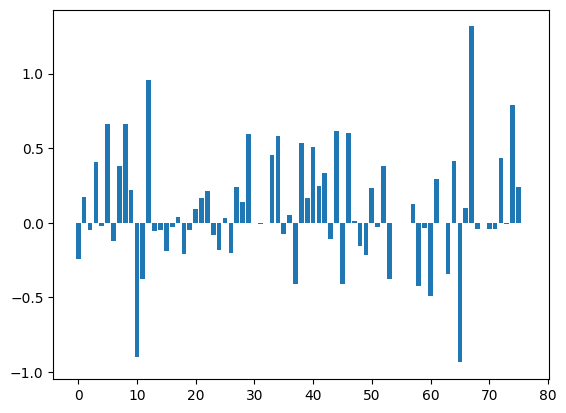

In [78]:
# Plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [85]:
import matplotlib.pyplot as plt

importances = pd.DataFrame(data={
    'Attribute': X_tr.columns,
    'Importance': lreg.coef_[0]
})
#importances = importances.sort_values(by='Importance', ascending=False)

In [90]:
importances.to_csv('lreg_feature_importances.csv')

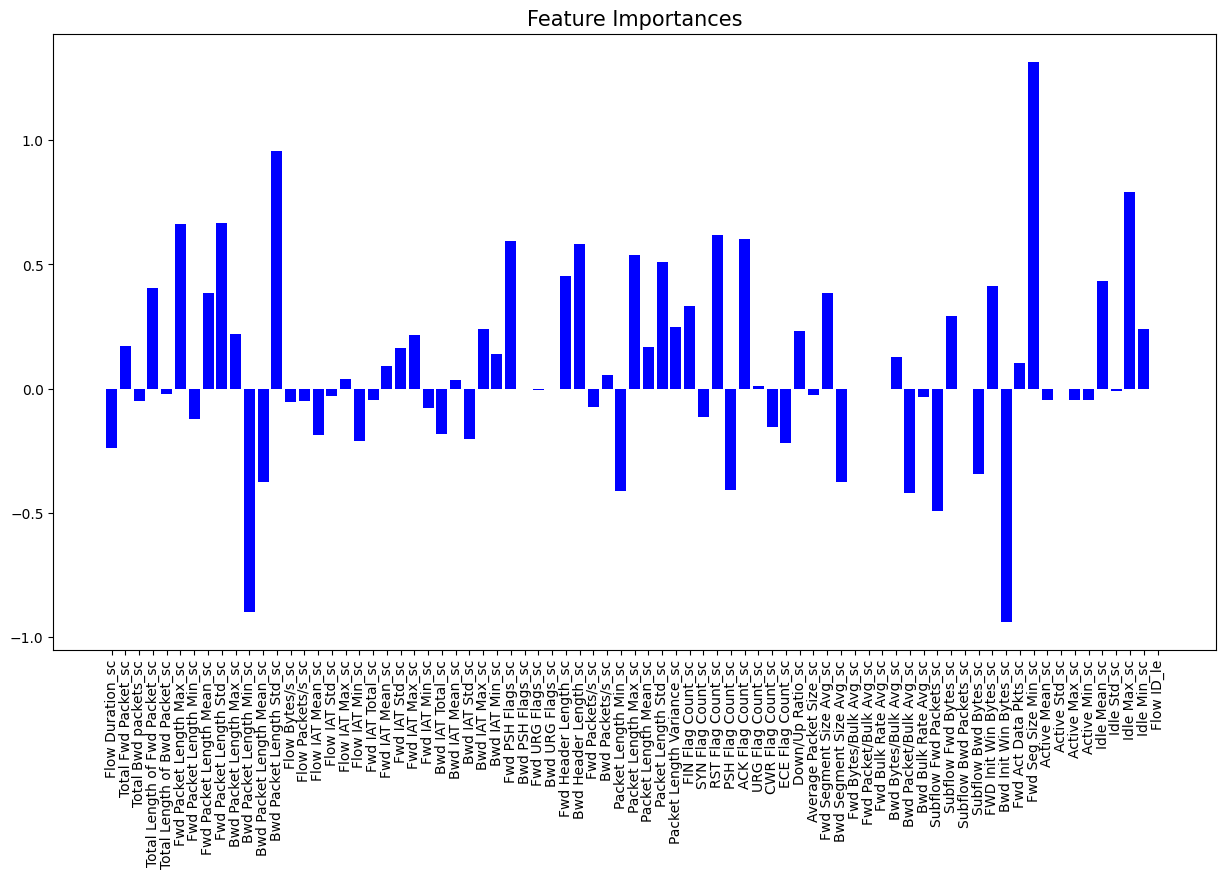

In [89]:
plt.figure(figsize=(15, 8))
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='Blue')
plt.title('Feature Importances', size=15)
plt.xticks(rotation='vertical')
plt.show()

### Decision Tree

Can be useful for initial analysis due to their ability to visualize decision-making paths.

In [38]:
print("Will not use following columns that are already encoded:", "\n",cols_to_drop)
print("\n +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
print("Will be using following features:",cols_numerical_sc, cat_enc_columns)
print("\n +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")

Will not use following columns that are already encoded: 
 ['Flow ID', 'Flow Duration', 'Total Fwd Packet', 'Total Bwd packets', 'Total Length of Fwd Packet', 'Total Length of Bwd Packet', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Packet Length Min', 'Packet Length Max', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag

In [42]:
from sklearn.tree import DecisionTreeClassifier


dtc = DecisionTreeClassifier(random_state=0, 
                             criterion="entropy",
                             max_depth=10)

dtc.fit(X_tr, y_tr)

dtc_pred = dtc.predict(X_tst)

print("Accuracy on Test set: {:.3f}".format(dtc.score(X_tr, y_tr)))

print("Accuracy on Test set: {:.3f}".format(dtc.score(X_tst, y_tst)))

f1_dtc = f1_score(y_tst, dtc_pred, average='weighted')
print("Test F1 score:...",f1)

print("==Test Confusion Matrix==")
print(confusion_matrix(y_tst, dtc_pred))
print("\n")

Accuracy on Test set: 1.000
Accuracy on Test set: 0.999
Test F1 score:... 0.9750968456004427
==Test Confusion Matrix==
[[55034    25]
 [    7   896]]




In [55]:
# Produce visualization of the model feature importance's using permutation method.
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

%matplotlib inline
result = permutation_importance(
    dtc, X_tst, y_tst)

feature_names = X_tst.columns
tree_importances = pd.Series(result.importances_mean, index=feature_names)
tree_importances = tree_importances.sort_values(ascending=False)

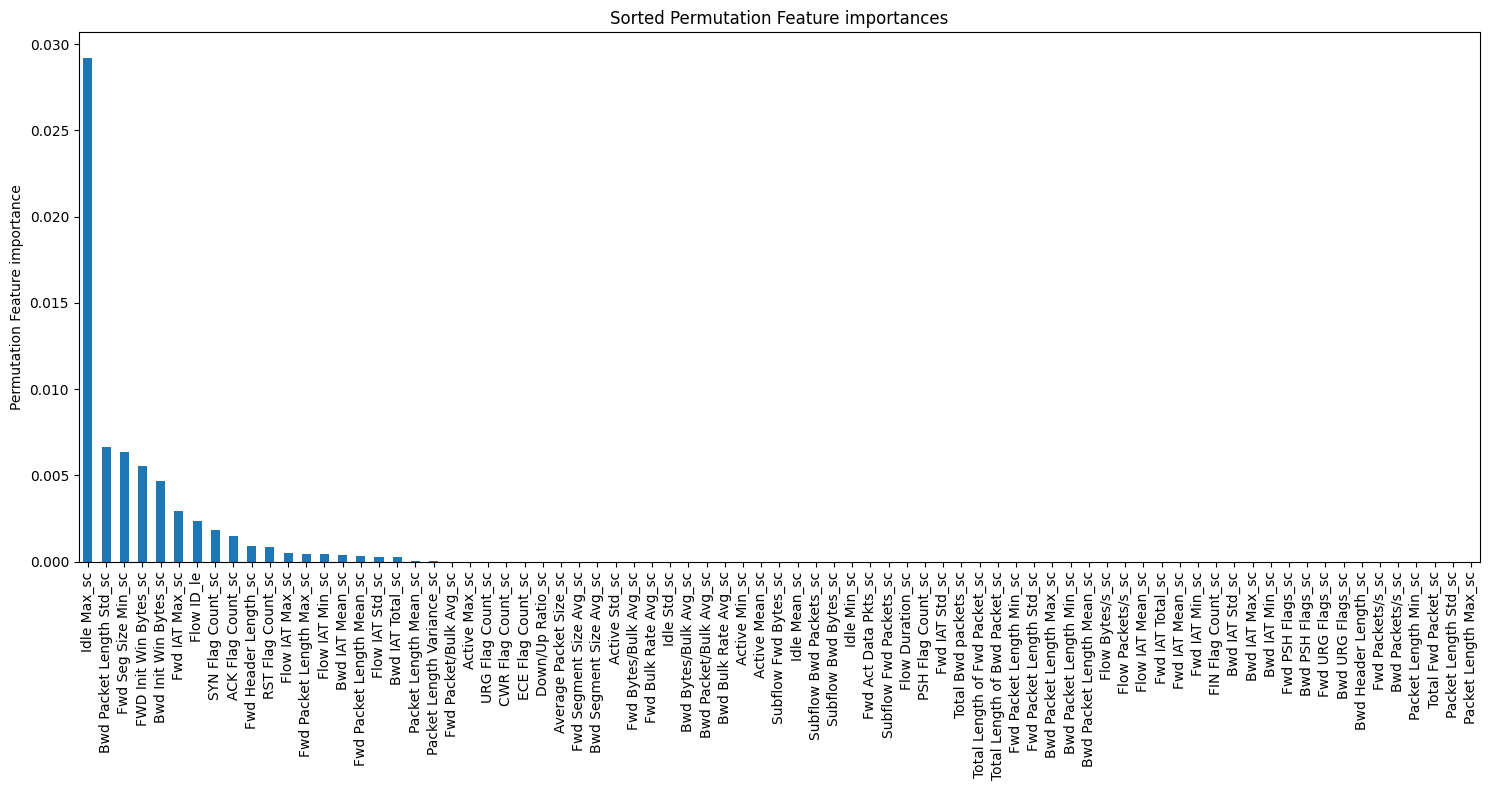

In [72]:
fig, ax = plt.subplots(figsize=(15,8))
tree_importances.plot.bar()
ax.set_title("Sorted Permutation Feature importances")
ax.set_ylabel("Permutation Feature importance")
fig.tight_layout()

### Random Forest

An ensemble method that combines multiple decision trees, offering improved accuracy and handling of complex data relationships.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_jobs=None,
                                    random_state=0,
                                    bootstrap=True,
                                    n_estimators=100,
                                    max_depth=None,
                                    max_features='sqrt',
                                    max_samples=None)

rfc.fit(X_tr, y_tr)

rfc_tst_pred = rfc.predict(X_tst)
rfc_tr_pred = rfc.predict(X_tr)

print("Accuracy on Train set: {:.3f}".format(rfc.score(X_tr, y_tr)))

print("Accuracy on Test set: {:.3f}".format(rfc.score(X_tst, y_tst)))

print("F1 for Train:", f1_score(y_tr, rfc_tr_pred, average='weighted'))

f1 = f1_score(y_tst, rfc_tst_pred, average='weighted')
print("F1 for Test:", f1)

print("Confusion matrix:")
print(confusion_matrix(y_tst, rfc_tst_pred))

Accuracy on Train set: 1.000
Accuracy on Test set: 0.999
F1 for Train: 1.0
F1 for Test: 0.9991552706639819
Test set confusion matrix:
[[55548    35]
 [   13   891]]


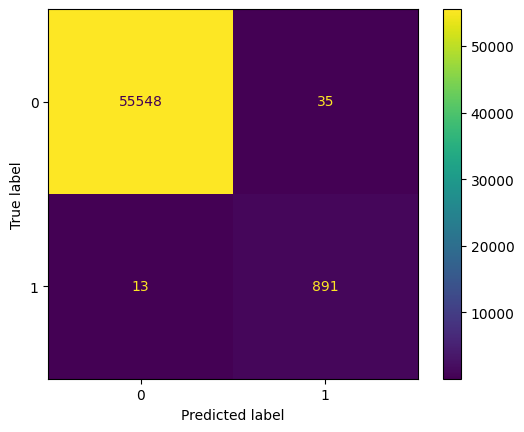

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_tst, rfc_tst_pred, labels=rfc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rfc.classes_)
disp.plot()
plt.show()

In [ ]:
# Classification report for Log-regression prediction
from sklearn.metrics import classification_report

print(classification_report(y_tst, rfc_tst_pred, target_names=["not one", "one"], 
                            zero_division=0))

              precision    recall  f1-score   support

     not one       1.00      1.00      1.00     55583
         one       0.96      0.99      0.97       904

    accuracy                           1.00     56487
   macro avg       0.98      0.99      0.99     56487
weighted avg       1.00      1.00      1.00     56487



In [ ]:
from sklearn.metrics import precision_recall_curve

# Get arrays of precision and recall for various probability thresholds
precision, recall, thresholds = precision_recall_curve(y_true=y_tst, 
                                                       probas_pred=rfc.predict_proba(X_tst)[:,1])

In [ ]:
# Calculate index for the best probability threshold
best_f1 = 0
best_f1_id = 0
for id, (pr, rc, threshold) in enumerate(zip(precision, recall, thresholds)):
    f1 = 2*(pr*rc)/(pr+rc)
    if f1 > best_f1:
        best_f1 = f1
        best_f1_id = id

print("Best f1:", best_f1)
print("Index of threshold:",best_f1_id)
print("Threshold for best F1:", thresholds[best_f1_id])

Best f1: 0.981737686773658
Index of threshold: 56
Threshold for best F1: 0.61
